# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [2]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
df_offers.head()

,Offer #,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [5]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Offer #           32 non-null     int64 
 1   Campaign          32 non-null     object
 2   Varietal          32 non-null     object
 3   Minimum Qty (kg)  32 non-null     int64 
 4   Discount (%)      32 non-null     int64 
 5   Origin            32 non-null     object
 6   Past Peak         32 non-null     bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 1.7+ KB


### 1b. Explore the data

In [6]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [7]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [8]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_name  324 non-null    object
 1   offer_id       324 non-null    int64 
 2   n              324 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [9]:
#your turn
df_customers = df_offers.merge(df_transactions, on='offer_id')
df_customer_orders = pd.pivot_table(df_customers, values='n', 
                                    index='customer_name', 
                                    columns='offer_id', 
                                    aggfunc='sum', 
                                    fill_value=0)

In [10]:
df_customer_orders

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Wilson,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
Wood,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [11]:
# your turn
# create numpy array with only columns representing the offers
x_cols = df_customer_orders.values


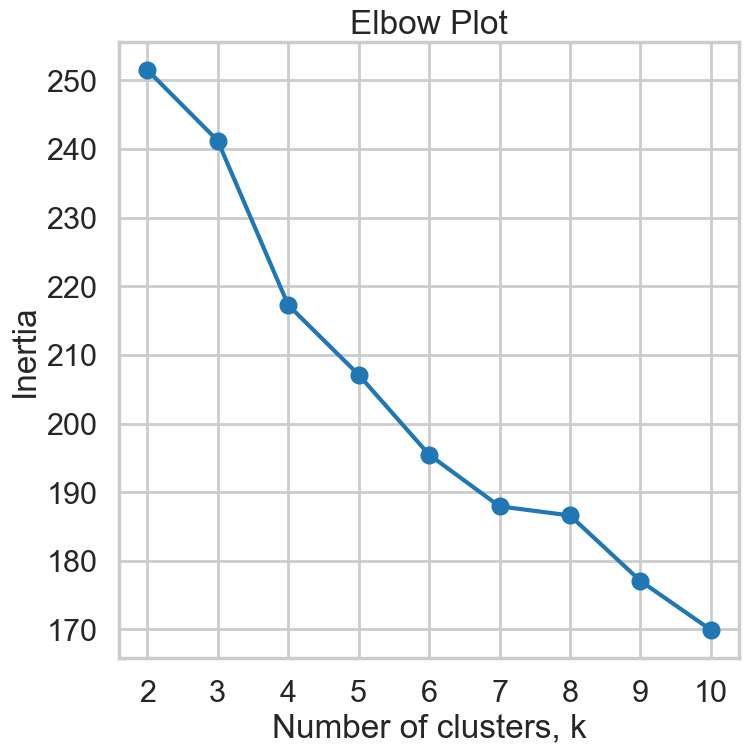

In [12]:
from sklearn.cluster import KMeans

k_values = range(2,11)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=3)
    labels = kmeans.fit_predict(x_cols)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Plot')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

In [13]:
# Make a bar chart showing the number of points in each cluster for k-means under the best K

kmeans = KMeans(n_clusters=4, random_state=3)
df_customer_orders['labels'] = kmeans.fit_predict(df_customer_orders)


In [14]:
df_customer_orders.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,labels
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
Anderson,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,3
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1


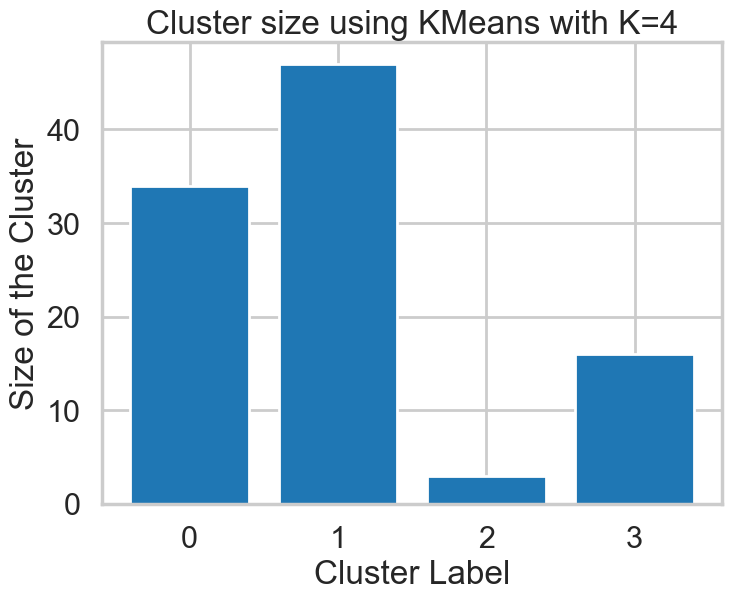

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
cluster_size = df_customer_orders['labels'].value_counts()
plt.bar(cluster_size.index, cluster_size)
ax.set(xlabel='Cluster Label', ylabel='Size of the Cluster', title='Cluster size using KMeans with K=4');

### Based on the Elbow Plot, it seems like k = 4 would be the optimal number of clusters. Although the inertia does not flatten out very clearly, it seems like the inertia does not make significant improvements for each iteration of k after k = 4. 

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [16]:
X = df_customer_orders.drop(columns='labels').values
k_values = range(2,11)

Note that the scikit-learn example of silhoutte plots and their associated scatter plots assumes only 2 features. I am going to conduct PCA to be able to reduce the dimensions of customer_orders_df so that I can perform a similar visual analysis in 2D that shows the transformed data points and their clusters.

In [17]:
from sklearn.decomposition import PCA

# Dimensionality reduction for second plot to show cluster groupings with their cluster centers
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

For n_clusters = 2 The average silhouette_score is : 0.09007566678796264
For n_clusters = 3 The average silhouette_score is : 0.09309016323097646
For n_clusters = 4 The average silhouette_score is : 0.12997009590812947
For n_clusters = 5 The average silhouette_score is : 0.10164457850942757
For n_clusters = 6 The average silhouette_score is : 0.11242572327123738
For n_clusters = 7 The average silhouette_score is : 0.11841308973056282
For n_clusters = 8 The average silhouette_score is : 0.09026837804070414
For n_clusters = 9 The average silhouette_score is : 0.10749079860888741
For n_clusters = 10 The average silhouette_score is : 0.11368917848730861


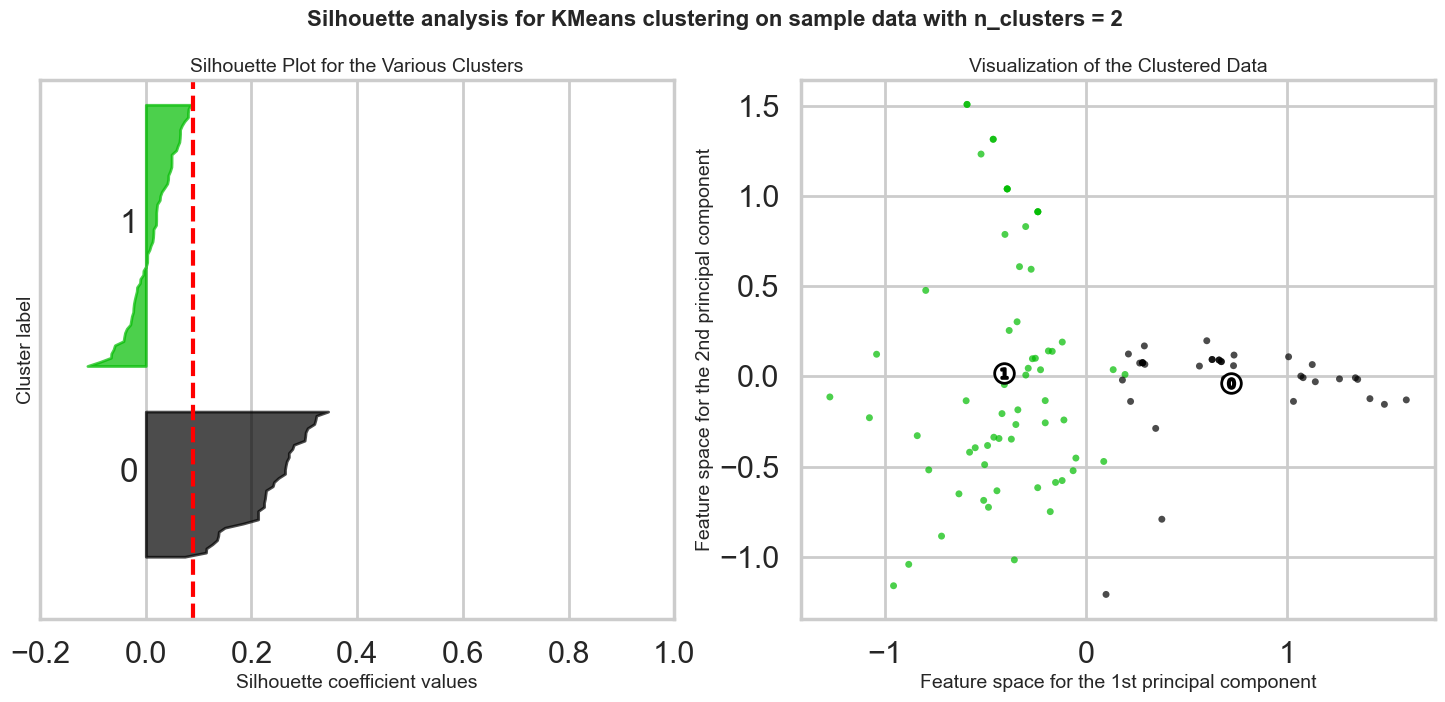

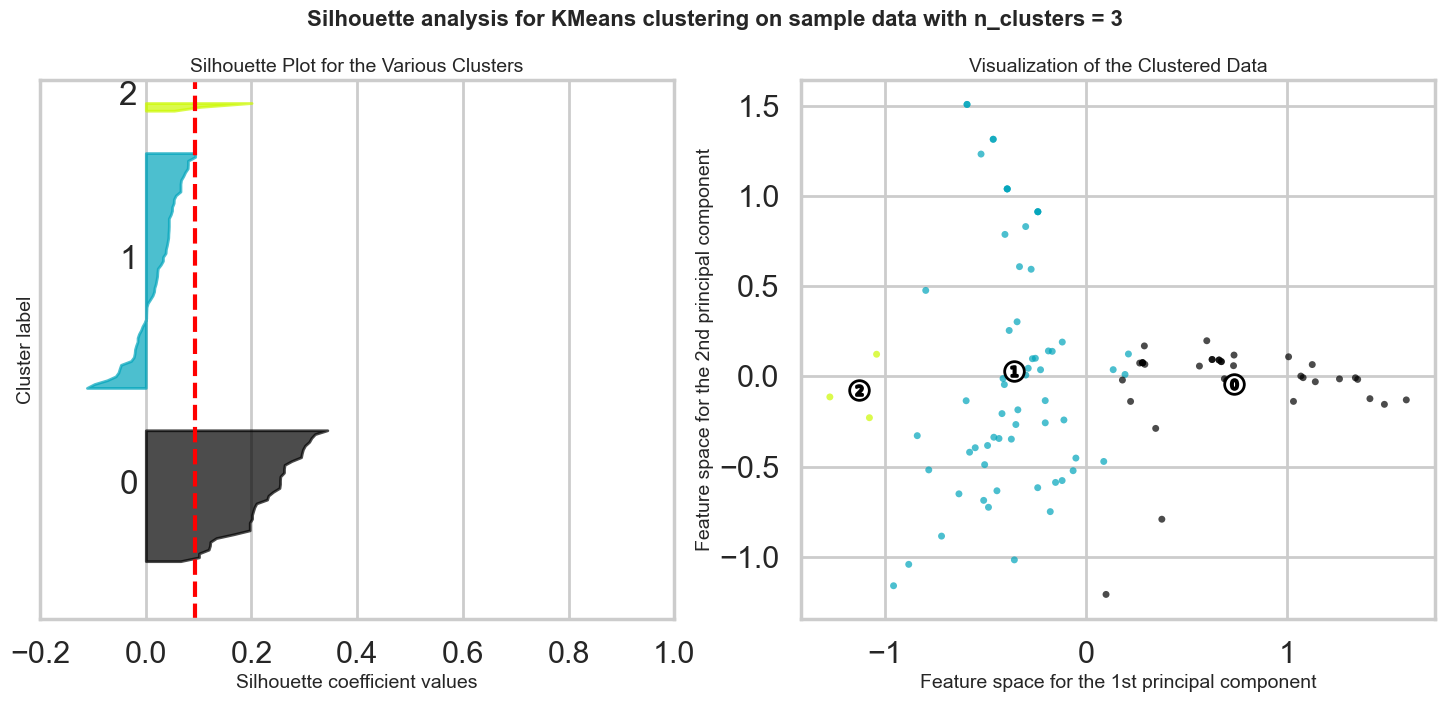

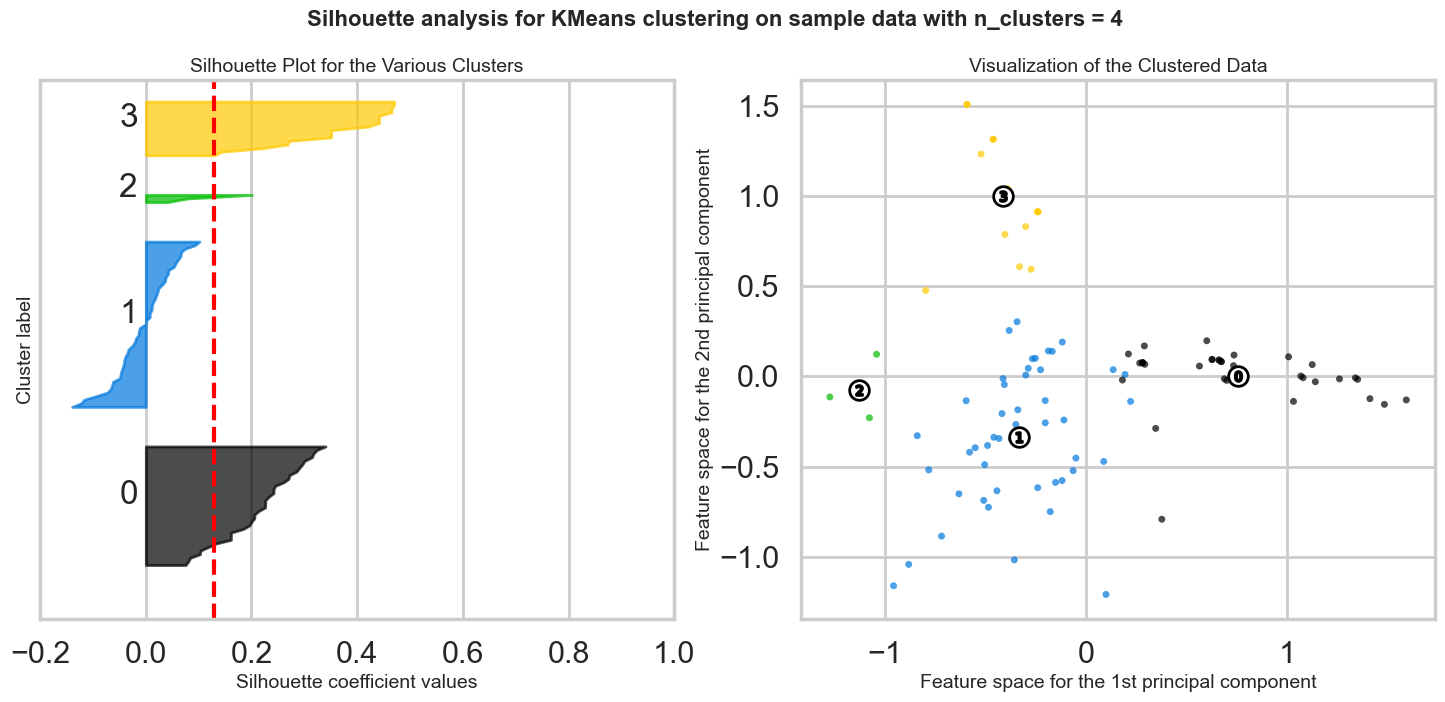

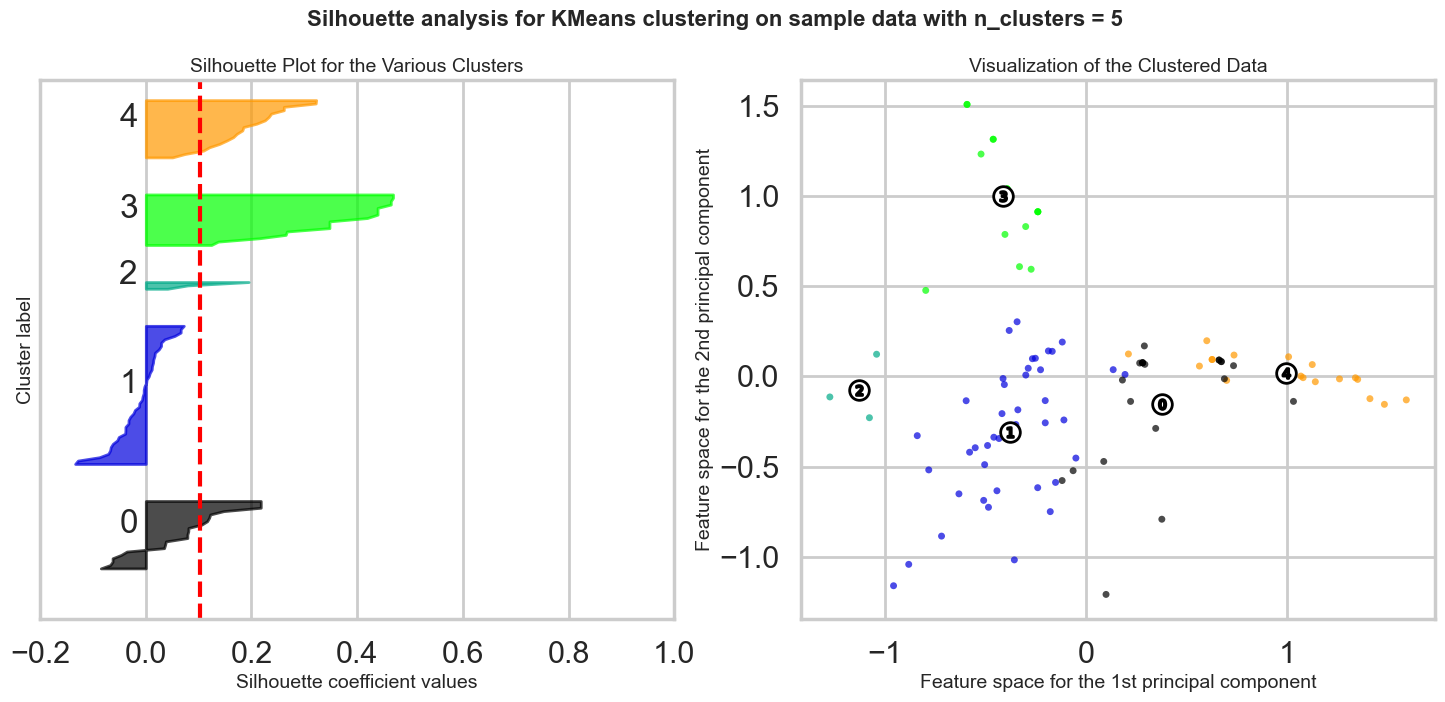

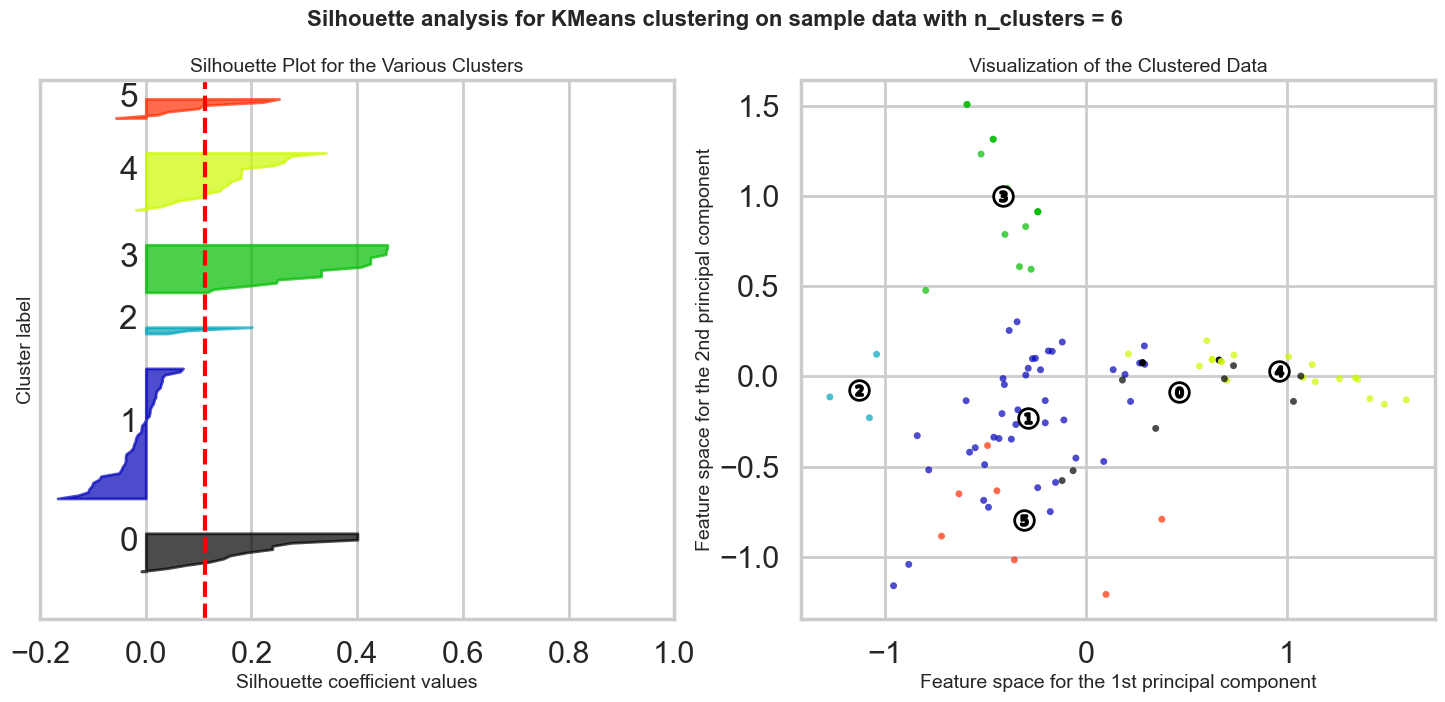

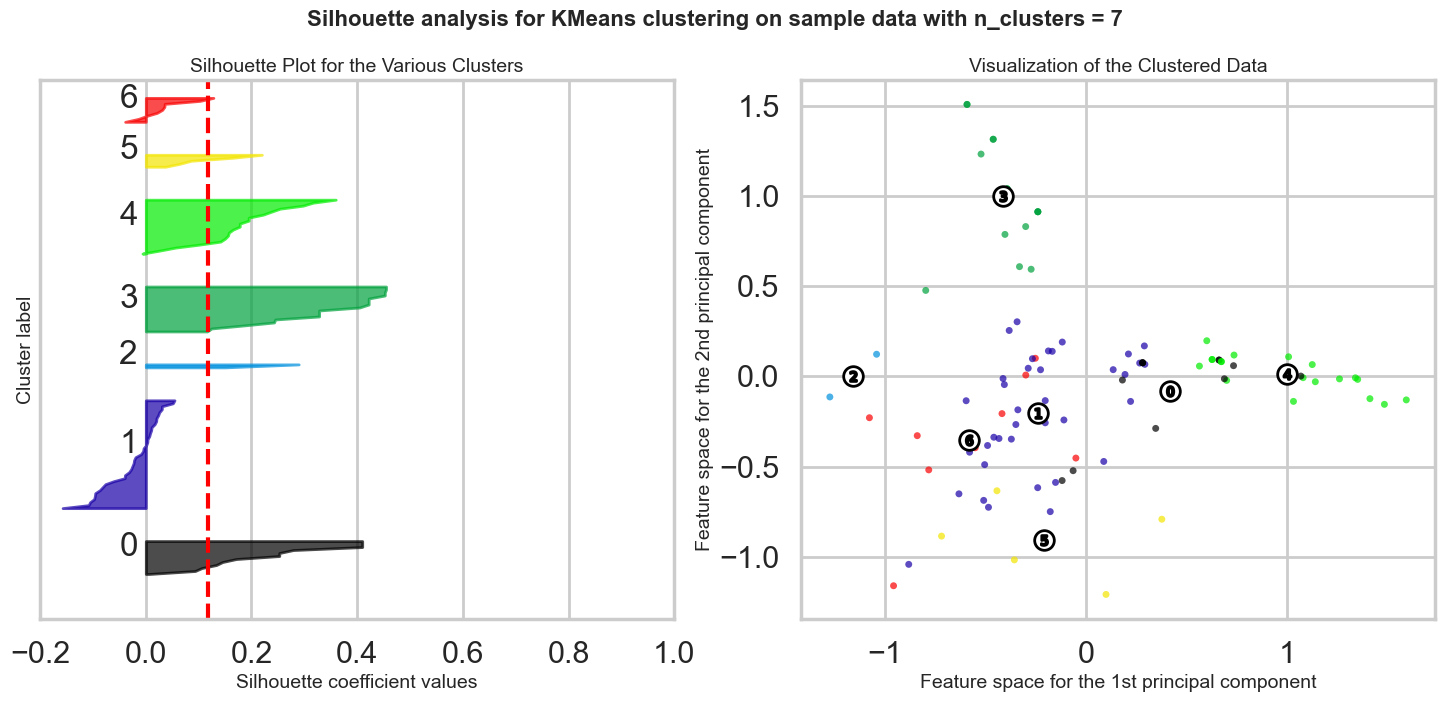

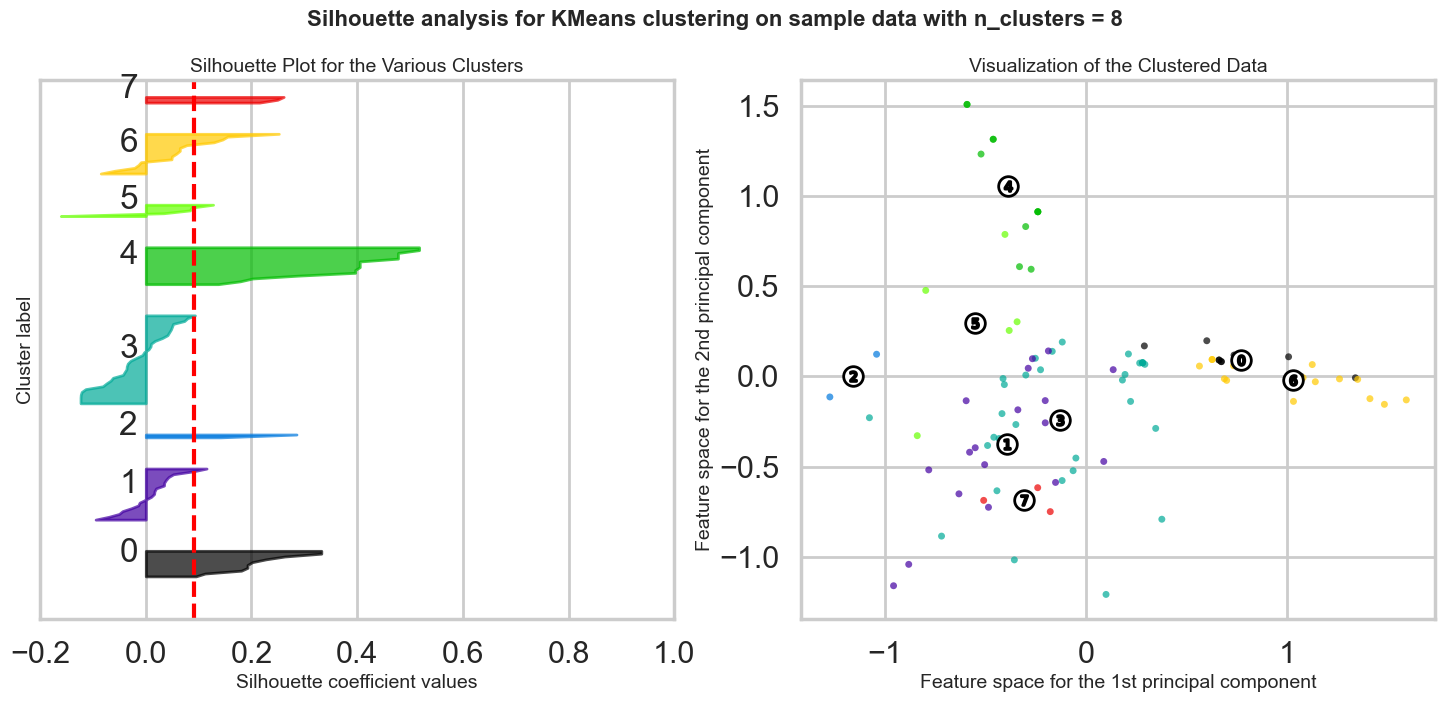

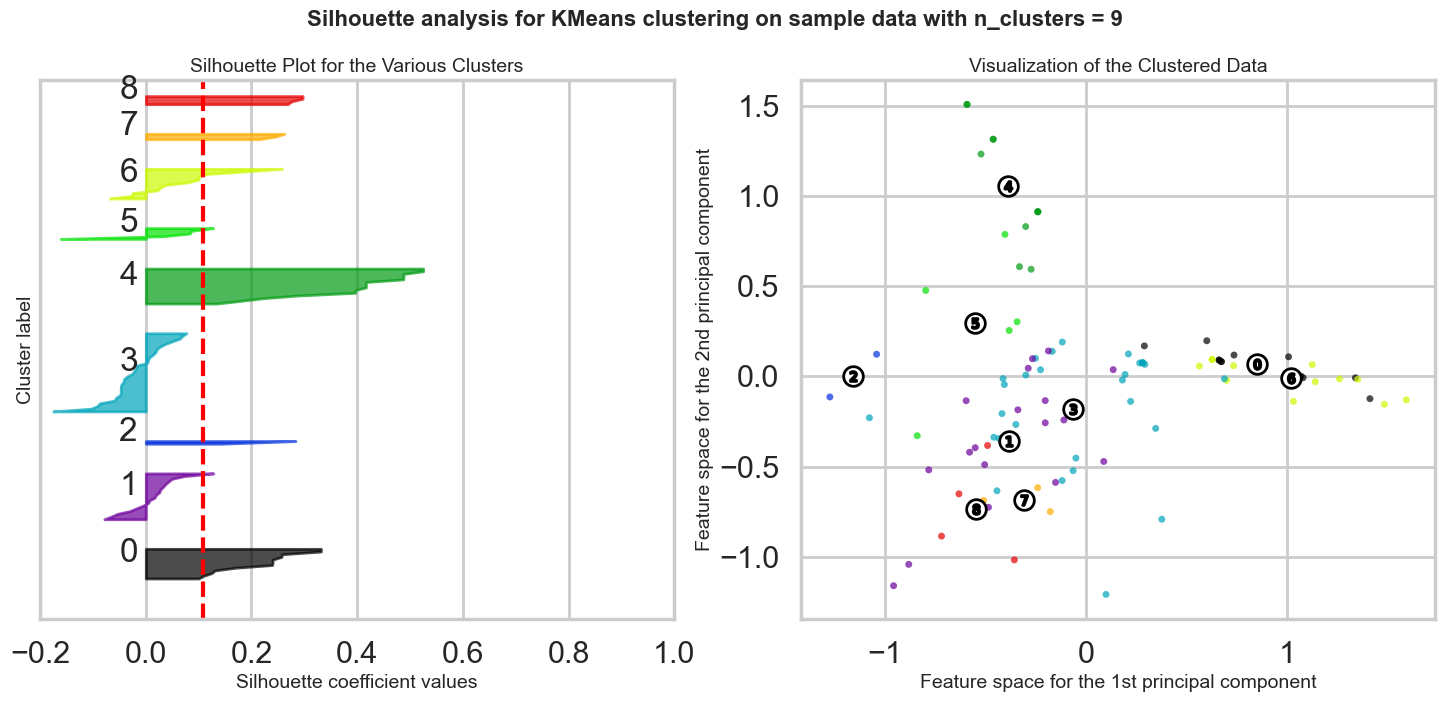

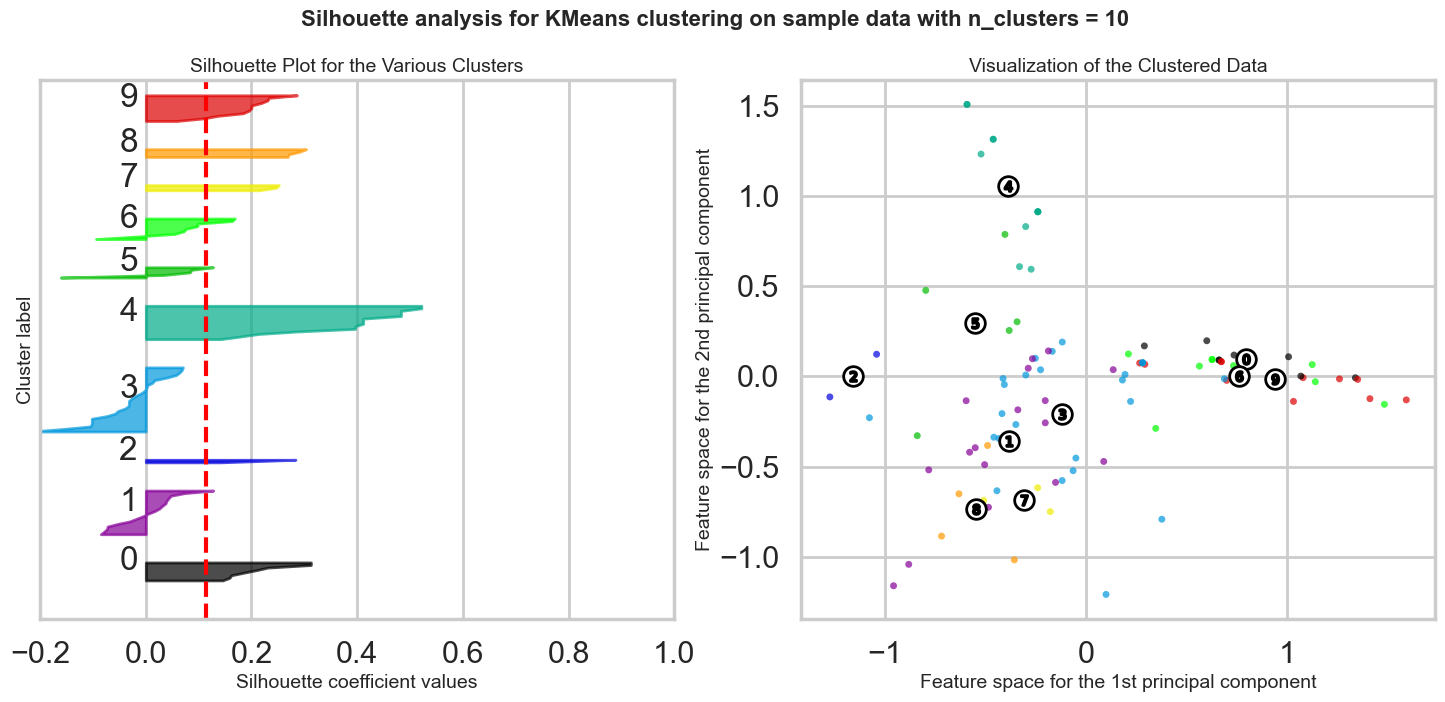

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

silhouette_avgerages = []

for k in k_values:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    font_size = 14

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 3 for reproducibility.
    kmeans = KMeans(n_clusters=k, random_state=3)
    cluster_labels = kmeans.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    silhouette_avgerages.append(silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # set distance between plots
    y_lower = 15
    
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette Plot for the Various Clusters", fontsize=font_size)
    ax1.set_xlabel("Silhouette coefficient values", fontsize=font_size)
    ax1.set_ylabel("Cluster label", fontsize=font_size)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        X_pca[:, 0], X_pca[:, 1], marker=".", s=100, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = kmeans.cluster_centers_

    # transform cluster centers to align with pca transformation of the data
    centers_pca = pca.transform(centers) 

    # Draw white circles at cluster centers
    ax2.scatter(
        centers_pca[:, 0],
        centers_pca[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers_pca):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of the Clustered Data", fontsize=font_size)
    ax2.set_xlabel("Feature space for the 1st principal component", fontsize=font_size)
    ax2.set_ylabel("Feature space for the 2nd principal component", fontsize=font_size)

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=16,
        fontweight="bold",
    )

plt.show()

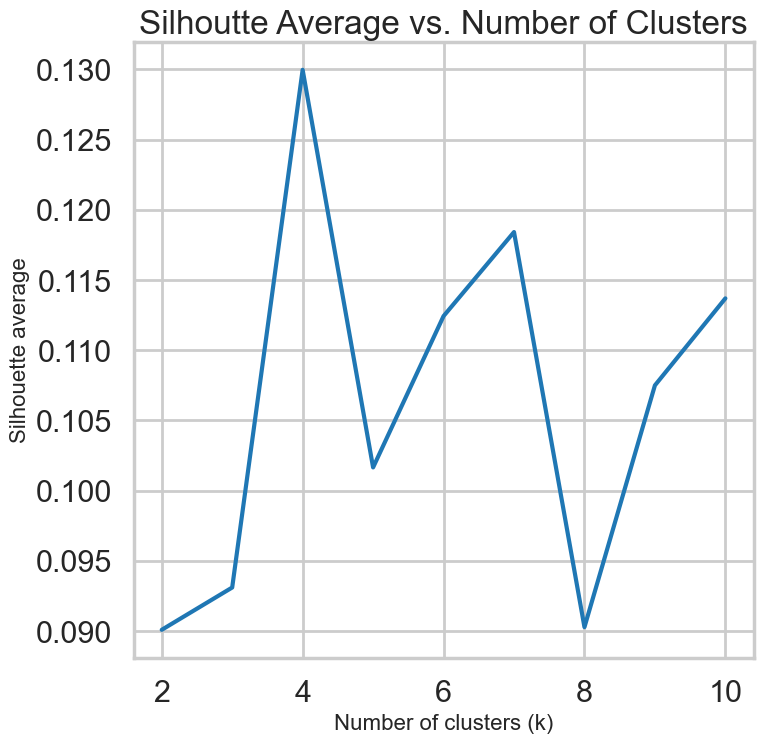

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
font_size=16
plt.plot(k_values, silhouette_avgerages)
plt.title('Silhoutte Average vs. Number of Clusters')
ax.set_xlabel('Number of clusters (k)', fontsize=font_size)
ax.set_ylabel('Silhouette average', fontsize=font_size)
plt.show()


## The silhoutte plots and the line plot showing the average silhoutte scores confirm the 4 clusters has the best outcomes, similar to what was observed in the Elbow Plot earlier. However, these plots also demonstrate that there is no substantial structure in the data. The optimal number of clusters only reaches a silhoutte score of 0.1299 which is below the 0.25 threshold to demonstrate any useful structure from the data's clusterings. 

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

Note that I already demonstrated PCA plots in the previous exercise because I thought we were supposed to model the sklearn article reference which showed the silhoutte plots alongside cluster plots. Since the sklearn example only had 2 features, I figured I needed to perform PCA to transform my plots into 2 components.

From my plots, it seems that with 4 clusters, the data seem to be best seggregated compared to other cluster sizes. We can see from the pca cluster plot that there are 4 groups with their appropriate cluster centers. Increasing the number of clusters seems to create nosie. I'll take a closer look at this below.

In [20]:
# perform KMeans modeling with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=3)

# create labels
labels = kmeans.fit_predict(X)

# find cluster centers
centers = kmeans.cluster_centers_

# transformer centers with PCA model
centers_pca = pca.transform(centers)

In [21]:
df_pca = pd.DataFrame({'customer_name':df_customer_orders.index, 'cluster_id':labels, 'x':X_pca[:,0], 'y':X_pca[:, 1]})
df_pca.head()

,customer_name,cluster_id,x,y
0,Adams,0,1.007580,0.108215
1,Allen,1,-0.287539,0.044715
2,Anderson,3,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,1,0.088183,-0.471695


In [22]:
from matplotlib import colormaps
# Get the tab20 colormap
tab20 = colormaps['tab20']

# Extract specific colors from tab20 using the indices 0, 7, and 15
custom_colors = [tab20(0), tab20(7), tab20(18), tab20(9)]

# Assuming you have cluster IDs 0, 1, 2 (corresponding to the colors you chose)
cluster_colors = {0: custom_colors[0], 1: custom_colors[1], 2: custom_colors[2], 3: custom_colors[3]}

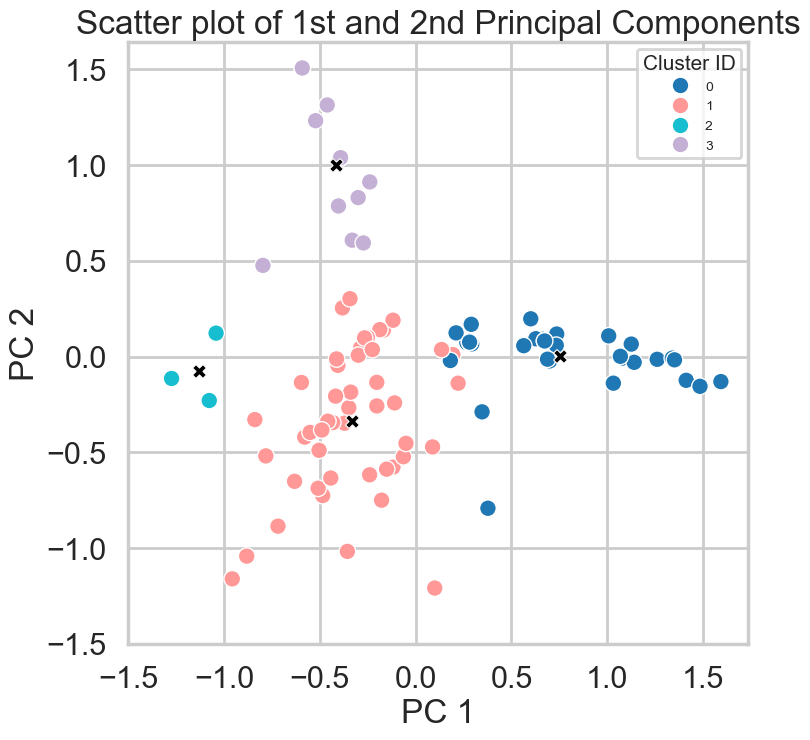

In [23]:
fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(data=df_pca, x='x', y='y', hue='cluster_id', palette=cluster_colors)
sns.scatterplot(x=centers_pca[:,0], y=centers_pca[:,1], s=100, marker='X', color='k')
ax.set_aspect('equal')

ax.set_xticks([-1.5, -1, -.5, 0, .5, 1, 1.5])
ax.set_yticks([-1.5, -1, -.5, 0, .5, 1, 1.5])

ax.set_title('Scatter plot of 1st and 2nd Principal Components')
ax.set(xlabel='PC 1', ylabel='PC 2')
ax.legend(title='Cluster ID', title_fontsize=15, fontsize=10)

In [24]:
clusters = df_pca['cluster_id'].value_counts().reset_index()
clusters.columns = ['cluster_id', 'cluster_count']
clusters['percent'] = clusters['cluster_count'] / clusters['cluster_count'].sum() * 100
clusters.sort_values('cluster_id')

,cluster_id,cluster_count,percent
1,0,34,34.0
0,1,47,47.0
3,2,3,3.0
2,3,16,16.0


### PCA and Clustering Analysis

The clusterings with the two principal components seem to be well grouped with little overlap. Clusters 1 and 2 have a some overlap. Cluster 2 has its points grouped relatively tightly around its center, suggesting a compact cluster. In contrast, clusters 0 and 1 seem more spread out, particularly cluster 0.

The distribution of points along the axes for PC 1 and PC 2 show suggest that these components do explain a lot of the variance seen in the data, but not all of it. The clusteres seem to have more variance along the PC 1 axis compared to PC 2.

It is clear the clusterings are heavily imbalanced. Cluster 1 has 47% of all data points and cluster 3 only has 3%. 

In [25]:
df_customers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [26]:
df_merged = df_pca.merge(df_customers, on='customer_name', how='inner')
df_merged.head()

,customer_name,cluster_id,x,y,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,n
0,Adams,0,1.007580,0.108215,18,July,Espumante,6,50,Oregon,False,1
1,Adams,0,1.007580,0.108215,29,November,Pinot Grigio,6,87,France,False,1
2,Adams,0,1.007580,0.108215,30,December,Malbec,6,54,France,False,1
3,Allen,1,-0.287539,0.044715,9,April,Chardonnay,144,57,Chile,False,1
4,Allen,1,-0.287539,0.044715,27,October,Champagne,72,88,New Zealand,False,1


In [27]:
df_merged['customer_name'].nunique()

100

In [28]:
df_merged['varietal'].value_counts()

varietal
Champagne             81
Pinot Noir            44
Prosecco              43
Espumante             40
Malbec                32
Cabernet Sauvignon    32
Merlot                20
Pinot Grigio          17
Chardonnay            15
Name: count, dtype: int64

In [29]:
list(df_merged['varietal'].unique())

['Espumante',
 'Pinot Grigio',
 'Malbec',
 'Chardonnay',
 'Champagne',
 'Pinot Noir',
 'Prosecco',
 'Cabernet Sauvignon',
 'Merlot']

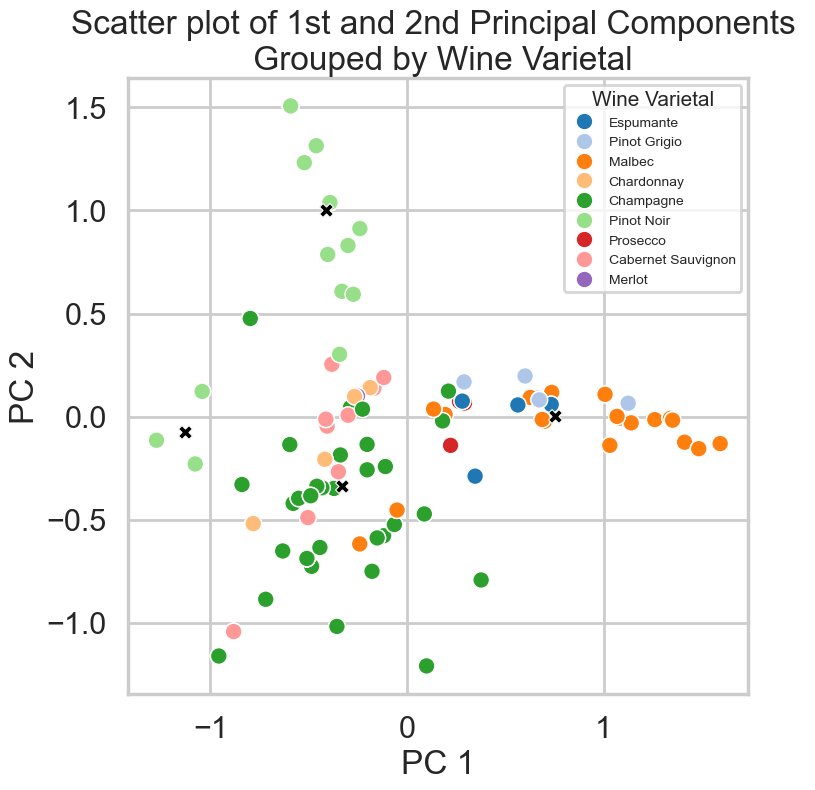

In [30]:
fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(data=df_merged, x='x', y='y', hue='varietal', palette='tab20')
sns.scatterplot(x=centers_pca[:,0], y=centers_pca[:,1], s=100, marker='X', color='k')
ax.set_title('Scatter plot of 1st and 2nd Principal Components \n Grouped by Wine Varietal')
ax.set(xlabel='PC 1', ylabel='PC 2')

ax.legend(title='Wine Varietal', title_fontsize=15, fontsize=10)

In [31]:
wine_dict = {'Espumante':'bubbly',
             'Pinot Grigio':'white',
             'Malbec':'red',
             'Chardonnay':'white',
             'Champagne':'bubbly',
             'Pinot Noir':'red',
             'Prosecco':'bubbly',
             'Cabernet Sauvignon':'red',
             'Merlot':'red'}

df_merged['varietal_grouped'] = df_merged['varietal'].map(wine_dict)

In [32]:
df_merged.pivot_table(values='n', index='cluster_id', columns='varietal', aggfunc='sum', fill_value=0)

varietal,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
cluster_id,,,,,,,,,
0,1,5,0,31,16,6,16,0,18
1,25,69,12,9,13,11,1,4,22
2,6,6,2,0,2,2,0,3,1
3,0,1,1,0,1,1,0,37,2


In [33]:
df_merged.pivot_table(values='n', index='cluster_id', columns='varietal_grouped', aggfunc='sum', fill_value=0)

varietal_grouped,bubbly,red,white
cluster_id,,,
0,54,23,16
1,100,53,13
2,7,13,2
3,3,39,1


Clusters 0 and 1 primarily purchase bubbly wines. Of bubbly wines, Cluster 0 purchases the most Espumante with a high number of order for Prosecco. Cluster 1 purchases more Champagne and Proseco than Espumante. 

Cluster 0 orders nearly all of the Pinot Grigio. 

Cluster 3 primarily purchases red wine, specifically Pinot Noir. Similarly, Cluster 2 red wine primarily, but most orders are for Cabernet Sauvignon. Cluster 2 also orders more varieties of red wines compared to Cluster 3. 

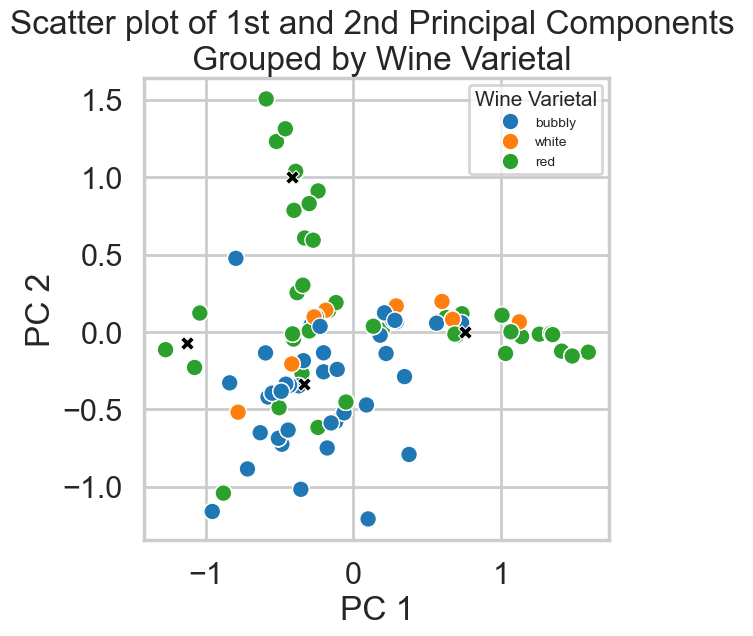

In [34]:
fig, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(data=df_merged, x='x', y='y', hue='varietal_grouped')
sns.scatterplot(x=centers_pca[:,0], y=centers_pca[:,1], s=100, marker='X', color='k')
ax.set_title('Scatter plot of 1st and 2nd Principal Components \n Grouped by Wine Varietal')
ax.set(xlabel='PC 1', ylabel='PC 2')
ax.legend(title='Wine Varietal', title_fontsize=15, fontsize=10)

In [35]:
df_merged.pivot_table(index='cluster_id', columns='origin', values='n', aggfunc='count', fill_value=0)

origin,Australia,California,Chile,France,Germany,Italy,New Zealand,Oregon,South Africa
cluster_id,,,,,,,,,
0,16,3,7,34,1,0,1,14,17
1,7,11,25,79,8,9,9,11,7
2,3,0,5,8,0,3,2,1,0
3,13,2,0,7,7,12,1,0,1


In [36]:
regions = {'Oregon': 'North America',
           'France':'Europe',
           'Chile':'South America',
           'New Zealand':'Australia',
           'Italy':'Europe',
           'Australia':'Australia',
           'California':'North America',
           'Germany':'Europe',
           'South Africa':'Africa'
           }

df_merged['origin_region'] = df_merged['origin'].map(regions)

In [37]:
df_merged.pivot_table(index='cluster_id', columns='origin_region', values='n', aggfunc='count', fill_value=0)

origin_region,Africa,Australia,Europe,North America,South America
cluster_id,,,,,
0,17,17,35,17,7
1,7,16,96,22,25
2,0,5,11,1,5
3,1,14,26,2,0


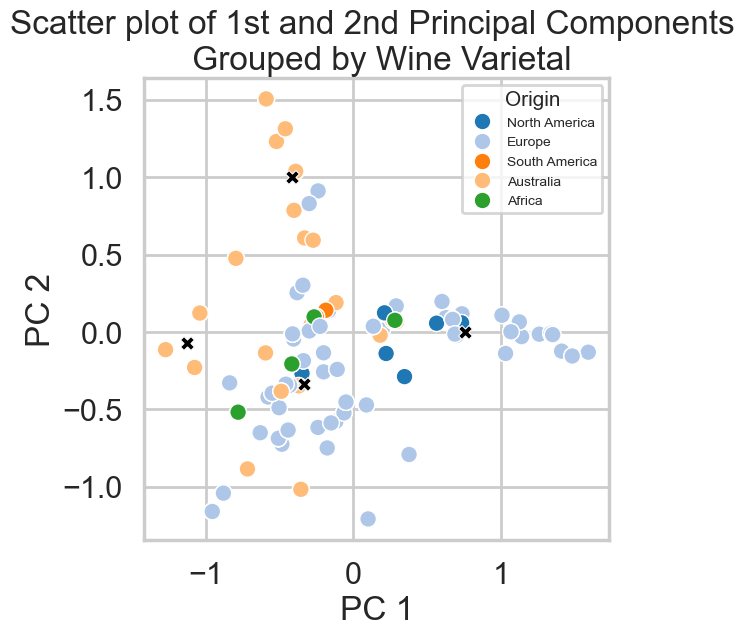

In [38]:
fig, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(data=df_merged, x='x', y='y', hue='origin_region', palette='tab20')
sns.scatterplot(x=centers_pca[:,0], y=centers_pca[:,1], s=100, marker='X', color='k')
ax.set_title('Scatter plot of 1st and 2nd Principal Components \n Grouped by Wine Varietal')
ax.set(xlabel='PC 1', ylabel='PC 2')
ax.legend(title='Origin', title_fontsize=15, fontsize=10);

In [39]:
months = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

df_merged['campaign_month'] = df_merged['campaign'].map(months)

In [40]:
df_merged.head()

,customer_name,cluster_id,x,y,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,n,varietal_grouped,origin_region,campaign_month
0,Adams,0,1.007580,0.108215,18,July,Espumante,6,50,Oregon,False,1,bubbly,North America,7
1,Adams,0,1.007580,0.108215,29,November,Pinot Grigio,6,87,France,False,1,white,Europe,11
2,Adams,0,1.007580,0.108215,30,December,Malbec,6,54,France,False,1,red,Europe,12
3,Allen,1,-0.287539,0.044715,9,April,Chardonnay,144,57,Chile,False,1,white,South America,4
4,Allen,1,-0.287539,0.044715,27,October,Champagne,72,88,New Zealand,False,1,bubbly,Australia,10


In [41]:
df_merged.pivot_table(values='n', index='cluster_id', columns='campaign_month', aggfunc='sum', fill_value=0, margins=True)

campaign_month,1,2,3,4,5,6,7,8,9,10,11,12,All
cluster_id,,,,,,,,,,,,,
0,0,1,33,1,7,0,14,3,0,1,17,16,93
1,11,16,17,13,14,16,5,25,4,12,6,27,166
2,2,5,1,2,2,3,0,3,0,4,0,0,22
3,7,0,0,1,1,1,7,0,13,13,0,0,43
All,20,22,51,17,24,20,26,31,17,30,23,43,324


The most popular months for purchases were:
* March: 51 purchases
* December: 43 purchases
* August: 31 purchases
* October: 30 purchases

Cluster 1 makes consistent purchases all year long compared to other clusters. 

Clusters 2 and 3 did not make purchases in December. 

Cluster 3 did not make purchases in March or August. 

Cluster 0 made hardly any purchases in October. 

In [42]:
df_merged.pivot_table(values='n', index='cluster_id', columns='min_qty', aggfunc='sum', fill_value=0)

min_qty,6,12,72,144
cluster_id,,,,
0,83,4,4,2
1,15,11,106,34
2,0,0,13,9
3,12,7,11,13


Cluster 0 makes more purchases for wines with lower minimum quanitites. 

Cluster 2 exclusively makes purchases for higher minumum quanitites (72 or 144).

Cluster 1 makes the most purchases overall, with a high number of puchases for minimum quantites of 72 and 34. 

In [43]:
df_merged.pivot_table(values='n', index='cluster_id', columns='past_peak', aggfunc='sum', fill_value=0)

past_peak,False,True
cluster_id,,
0,76,17
1,132,34
2,16,6
3,43,0


Cluster 3 does not make any purchases of wines that are past their peak. 

In [44]:
df_merged.groupby('cluster_id')['discount'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_id,,,,,,,,
0,93.0,55.430108,16.893141,32.0,45.0,50.0,54.00,88.0
1,166.0,63.132530,20.177858,17.0,50.0,63.0,85.00,89.0
2,22.0,63.454545,18.173050,19.0,50.0,61.0,82.75,86.0
3,43.0,52.116279,25.205073,17.0,34.0,47.0,83.00,88.0


[Text(0.5, 0, 'Cluster ID'), Text(0, 0.5, 'Discount')]

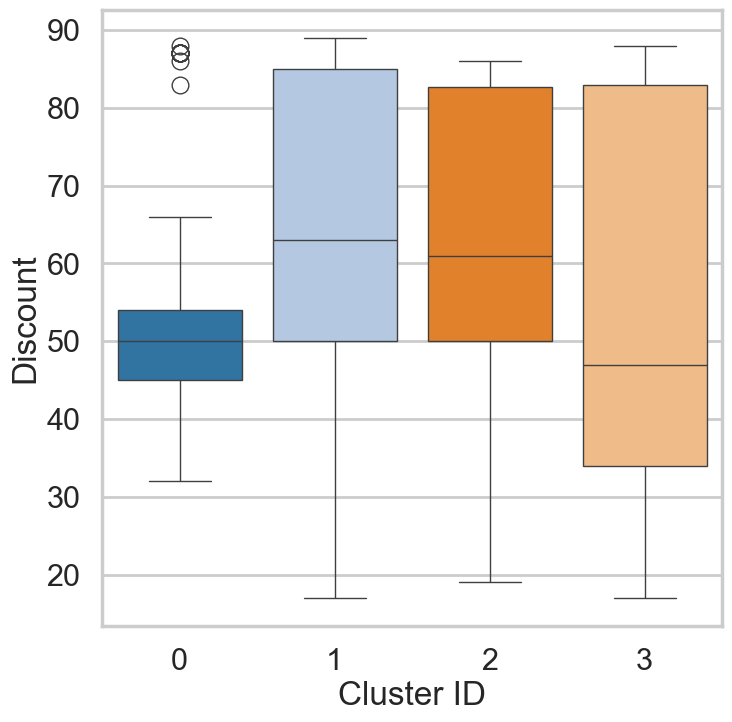

In [45]:
fig, ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=df_merged, x='cluster_id', y='discount', hue='cluster_id', palette='tab20' ,legend=False)
ax.set(xlabel='Cluster ID', ylabel='Discount')

Cluster 0 typically makes purchases when discounts are at least 32% or higher. Cluster 0 also has a smaller range of discount ranges compared to other clusters. 

Cluster 3 has the widest range of purchases when considering discounts. Most of their purchases fall in a discount range of 34% to 83%. By comparison, clusters 1 and 2 make most of their purchases with discounts between 50% and 85%. 

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [46]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

features = range(pca.n_components_)
df_variance = pd.DataFrame({'pc_feature':features, 'explained_var_ratio':pca.explained_variance_ratio_})
df_variance['cumulative_ratio'] = df_variance['explained_var_ratio'].cumsum()


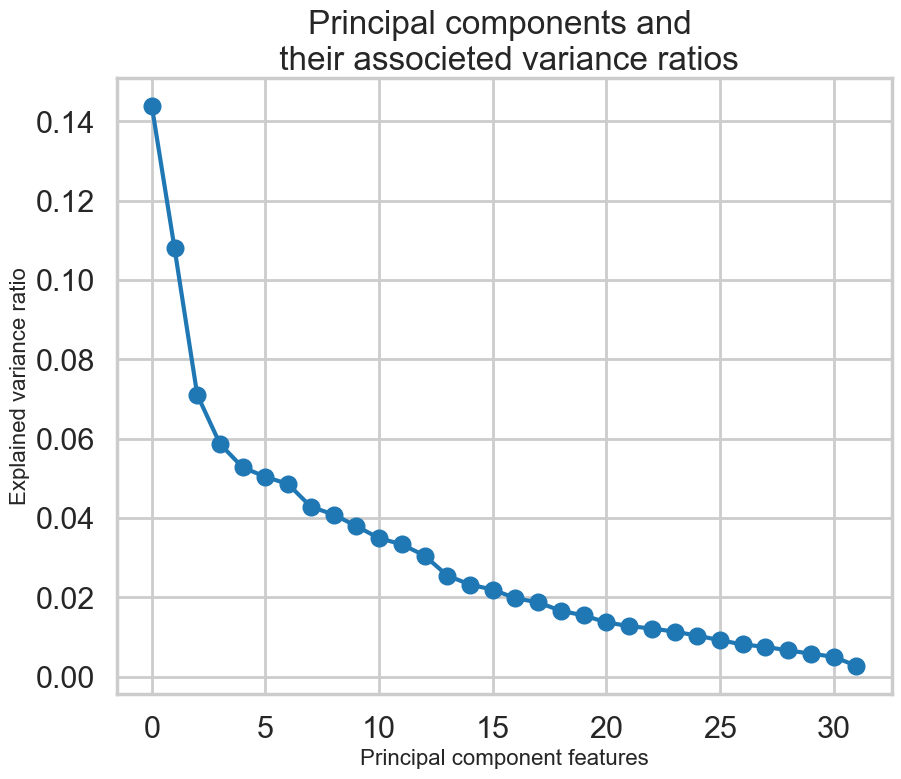

In [47]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(features, pca.explained_variance_ratio_, marker='o')
plt.title('Principal components and \n their associeted variance ratios')
ax.set_xlabel('Principal component features', fontsize=font_size)
ax.set_ylabel('Explained variance ratio', fontsize=font_size);

In [48]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Assuming your DataFrame is named df and has columns 'feature', 'explained_var_ratio', 'cumulative_ratio'

def update_plot(threshold):
    # Find the index where cumulative_ratio reaches or exceeds the user-defined threshold
    components_threshold = df_variance[df_variance['cumulative_ratio'] >= threshold].index[0] + 1

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.plot(df_variance['pc_feature'], df_variance['explained_var_ratio'], marker='o')
    plt.title('Principal components and \n their associated variance ratios')
    ax.set_xlabel('Principal component features', fontsize=12)
    ax.set_ylabel('Explained variance ratio', fontsize=12)

    # Add a vertical line at the point where cumulative variance reaches the threshold
    ax.axvline(x=components_threshold, 
               color='red', 
               linestyle='--', 
               label=f'{threshold*100}% variance at {components_threshold} PCs')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()

# Create an interactive slider widget for the threshold
threshold_slider = widgets.FloatSlider(value=0.80, min=0, max=1.0, step=0.01, description='Threshold:', continuous_update=False)

# Use the interactive function to update the plot based on the slider value
widgets.interactive(update_plot, threshold=threshold_slider)


interactive(children=(FloatSlider(value=0.8, continuous_update=False, description='Threshold:', max=1.0, step=…

### Ideally, the number of principal components chosen should explain between 80-90% of the variance observed in the data. The graph shows that to explain at least 80% of the variance, we would ned to select 15 principal components. After the third principal component, the curve's rate of descent decreases more slowly. However, if we select 3 principal components, only 31% of the variance is explained.  

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### Affinity Propagation

In [106]:
from sklearn.cluster import AffinityPropagation

affinity_propagation = AffinityPropagation(random_state=3)

clustering = affinity_propagation.fit(X)

affinity_labels = affinity_propagation.labels_

array([ 0,  9,  6,  3, 11, 11,  6, 13,  4,  2,  8, 12,  2, 11,  4,  6, 13,
        6,  0,  1,  2, 13,  4,  8,  6,  9, 10,  4,  9, 12,  3, 13,  4,  7,
       13,  5,  4,  2,  4,  5,  6,  6, 13, 11,  3,  7,  2,  3,  9,  4,  1,
       11, 12,  6,  3, 13,  6,  3,  0, 13, 11, 13, 11,  0,  0, 12,  6, 10,
        8,  9, 10,  9,  7,  3, 11,  3, 12, 13,  0, 12, 10,  9, 10, 12,  2,
        5,  0,  9,  9, 13, 11,  0, 13,  3,  1, 11, 13, 11,  7, 11])